# TP 1 et 2: Linear Discriminant Analysis (LDA)


Enseignants: 

    S. Zhang (2022), J. Chirinos-Rodriguez (2025) (jonathaneduardo.chirinosrodriguez@toulouse-inp.fr)


Ce TP couvre **2 séances**. Le but est de classifier des simulations du milieu interstellaire. Nous allons réaliser des analyses discriminantes linéaires (LDA) en utilisant différents estimateurs statistiques :
1. la moyenne empirique
2. la matrice d'autocovariance empirique
3. le spectre de puissance

On comparera ensuite les performances de ces différentes méthodes.

On pourra se référer à cette page Wikipédia sur la LDA: https://fr.wikipedia.org/wiki/Analyse_discriminante_lin%C3%A9aire

**Evaluation :**
Ce notebook sera évalué. Il comptera pour 15% de la note finale. Le notebook devra être rendu avant le **06 Juin 2025**.

Critères d'évaluation : 
- code qui tourne (sans retourner d'erreur) et est-ce que le code répond à la question.
- clareté : commentaires, docstrings pour les fonctions, axes, titre et légende sur les plots...
- effort de recherche et mise en application des concepts du cours.

**Acknowledgements: L. Mousset (2023), P. Richard (2024)**

In [1]:
# Pour les plots
%matplotlib inline
import matplotlib.pyplot as plt

# Calcul scientifique
import numpy as np
import scipy
from scipy.fft import fft2

# Librairie maison dans le dossier avec les notebooks
from utils import bin_to_float, convert_cls2fls, save_obj, load_obj

# Librairie Scikit Learn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score

## Charger les données

On va utiliser des cartes (256x256) pixels, ce sont des simulations du milieu interstellaire. Plusieurs jeux de simulations ont été réalisés en variant deux paramètres physiques : le champ magnétique et la température. En fonction des valeurs de ces deux paramètres, on a pu définir 9 classes. 

On lit les données qui sont stockées dans le dossier `data/`. Les cartes sont séparées en deux catégories:
- Train : les données d'apprentissage (= d'entrainement)
- Test : les données de validation réservées aux tests

Chaque catégorie est séparée en 9 classes. Pour la catégorie Train, chaque classe contient 20 images alors que pour la catégorie Test, chaque classe contient 15 images.

Les images sont stockées en format binaire dans des fichiers `.dat`. Ces fichiers sont des tableaux 1D (256x256x8) où le 8 correspond aux 8 bytes.

In [2]:
# Paramètres
NbClasses = 9
SizeMaps = 256
TrainBaseFolder = './data/LearnEchantillons'
NbMapsTrain = 20
TestBaseFolder = './data/ClassEchantillons'
NbMapsTest = 15

**0.1 TODO :** Ecrire une fonction qui charge les données. Elle doit retourner un dictionnaire de numpy arrays (#Images, 256, 256), chaque élément du dictionnaire correspondant à une classe. On pourra utiliser la fonction `np.fromfile()`.

In [3]:
def read_imgs(BaseFolder: str, NbClasses: int, NbMaps: int, SizeMaps: int) -> dict:
    imgs_cls = {}  # Initialisation du dictionnaire
    for i in range(NbClasses):  # Boucle sur les 9 classes
        imgs = np.zeros((NbMaps, SizeMaps, SizeMaps))
        # %%%%% TODO %%%%%
        for j in range(NbMaps):  # Boucle sur les images de la classe i
            filename = f"{BaseFolder}/{i+1}/{j+1}.dat"
            data = np.fromfile(filename, dtype=np.float64)
            imgs[j] = data.reshape((SizeMaps, SizeMaps))
        # %%%%% end TODO %%%%%
        
        imgs_cls[i] = imgs  # On met les images de la classe i dans le dictionnaire
        
    return imgs_cls

**0.2 TODO :** En appliquant la fonction `read_imgs()`, contruire 2 dictionnaires avec les données Test et les données Train

In [4]:
# %%%%% TODO %%%%%
ImgsTrain = read_imgs(TrainBaseFolder, NbClasses, NbMapsTrain, SizeMaps)
ImgsTest = read_imgs(TestBaseFolder, NbClasses, NbMapsTest, SizeMaps)
# %%%%% end TODO %%%%%

**0.3 TODO :**  Sauver chaque dictionnaire sous la forme d'un fichier pickles. On utilisera la fonction `save_obj()` de `utils.py()`.

In [5]:
# %%%%% TODO %%%%%
save_obj(ImgsTrain, 'ImgsTrain')
save_obj(ImgsTest, 'ImgsTest')
# %%%%% end TODO %%%%%

Remarque: Ces fichiers peuvent être chargés avec la fonction `load_obj`. Cela sera utile pour les prochains TPs.

In [6]:
ImgsTrain = load_obj('ImgsTrain')
ImgsTest = load_obj('ImgsTest')

**0.4 TODO :** Afficher des images de différentes classes. Peut-on différencier les classes à l'oeil nu ?

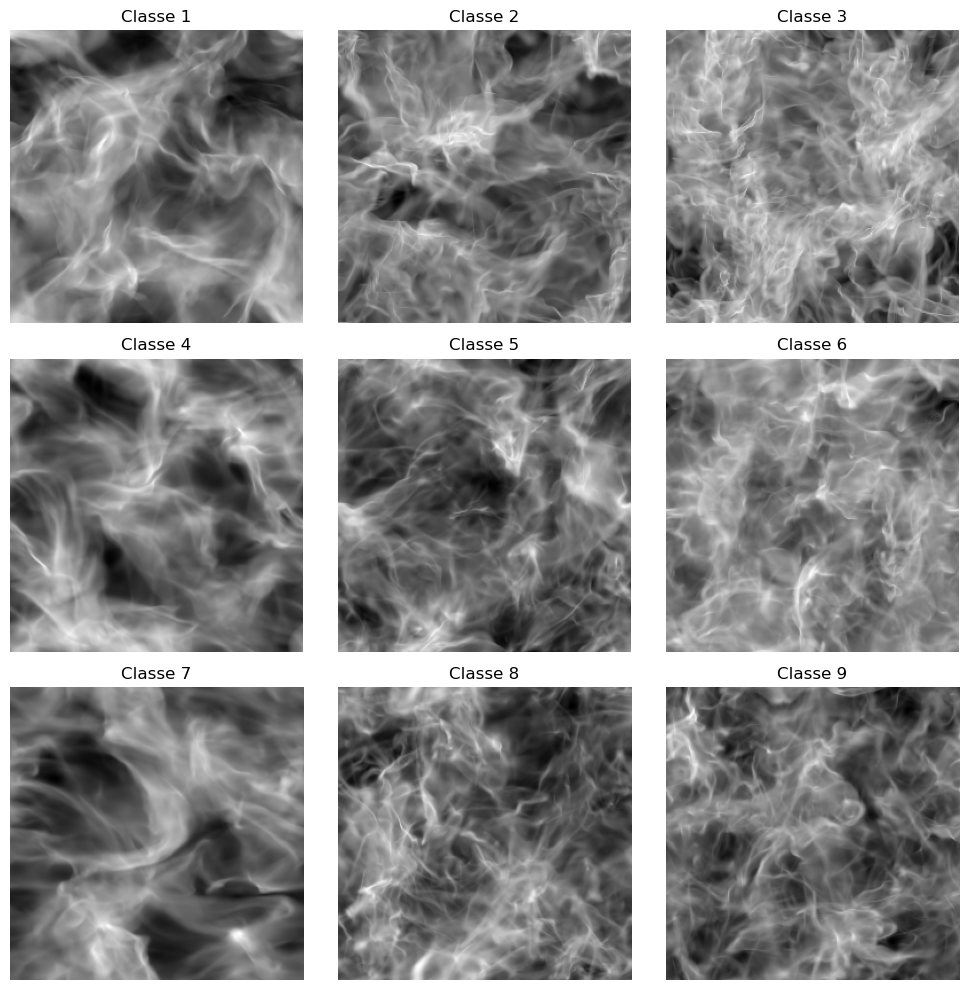

In [7]:
# %%%%% TODO %%%%%
### Plot
plt.figure(figsize=(10, 10))
for i in range(NbClasses):
    plt.subplot(3, 3, i + 1)
    plt.imshow(ImgsTrain[i][0], cmap='gray')
    plt.title(f'Classe {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()
# %%%%% end TODO %%%%%

**0.5 TODO :** Quelles conditions aux limites vérifient ces images ? On pourra faire un plot d'une image en utilisant la fonction `np.roll()` (https://stackoverflow.com/questions/19878280/efficient-way-to-shift-2d-matrices-in-both-directions).

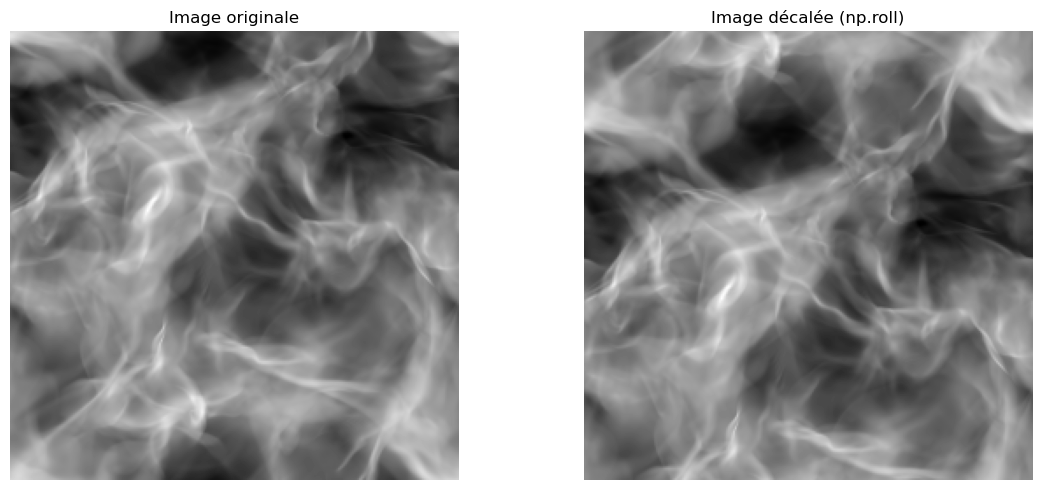

In [8]:
# %%%%% TODO %%%%%
### Plot
img = ImgsTrain[0][0]
shifted_img = np.roll(img, shift=50, axis=0)  # Décalage de 50 pixels selon l'axe vertical

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Image originale")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(shifted_img, cmap='gray')
plt.title("Image décalée (np.roll)")
plt.axis('off')

plt.tight_layout()
plt.show()

# %%%%% end TODO %%%%%

## Etape 1: Linear Discriminant Analysis (LDA) avec la moyenne empirique

**1.1 TODO :** Compléter la fonction suivante qui doit retourner un dictionnaire contenant la moyenne de chaque image.

In [9]:
def compute_features_mean(Imgs: dict, NbClasses: int, NbMaps: int) -> dict:
    mu_cls = {}
    # %%%%% TODO %%%%%
    for i in range(NbClasses):
        mu_cls[i] = np.mean(Imgs[i], axis=(1, 2))
    # %%%%% end TODO %%%%% 

    return mu_cls

**1.2 TODO :** Appliquer la fonction précédente pour construire deux dictionnaires associés aux cartes Train et Test. Afficher les valeurs des moyennes et les tracer sur un graphe. A votre avis, la moyenne est-elle un bon marqueur statistique pour classifier ces images ?

In [10]:
# %%%%% TODO %%%%%
MeanTrain = compute_features_mean(ImgsTrain, NbClasses, NbMapsTrain)
MeanTest = compute_features_mean(ImgsTest, NbClasses, NbMapsTest)
# %%%%% end TODO %%%%%

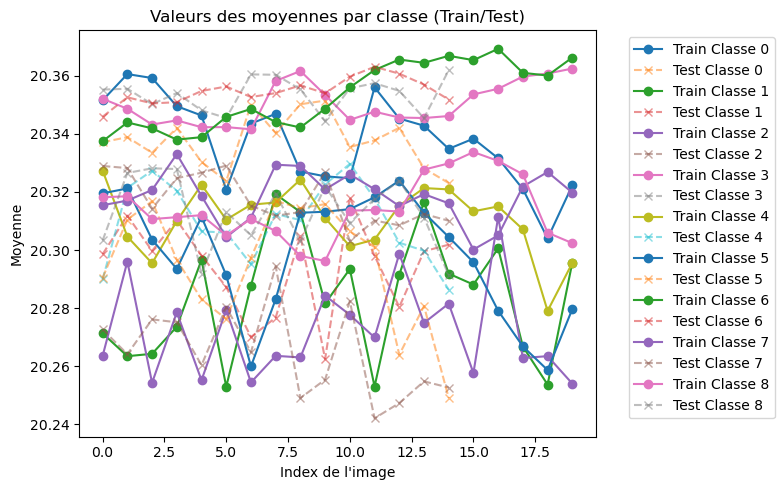

In [11]:
# %%%%% TODO %%%%%
### Plot
# Affichage des valeurs des moyennes pour chaque classe
plt.figure(figsize=(8, 5))
for i in range(NbClasses):
    plt.plot(MeanTrain[i], 'o-', label=f'Train Classe {i}')
    plt.plot(MeanTest[i], 'x--', label=f'Test Classe {i}', alpha=0.5)
plt.xlabel('Index de l\'image')
plt.ylabel('Moyenne')
plt.title('Valeurs des moyennes par classe (Train/Test)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# %%%%% end TODO %%%%%

**1.3 TODO :** Compléter la fonction suivante qui réalise la classification par LDA. **Cette fonction sera réutilisée dans les TP suivants.** En plus de la LDA, elle devra retourner les matrices de confusion et les test d'accuracy sur les données Train et Test. 

Nous allons utiliser la librairie scikit-learn. Voir éventuellement : https://scikit-learn.org/0.24/auto_examples/classification/plot_lda_qda.html?highlight=lda

Ne pas hésiter à prendre des fonctions toutes faites pour le calcul de confusion et d'accuracy.

In [12]:
def classify_by_LDA(dataTrain: dict, dataTest: dict) -> dict:
    
    # Construit les features et les labels des données Train et Test pour l'apprentissage supervisé via la fonction convert_cls2fls de utils.py().
    featuresTrain, labelsTrain = convert_cls2fls(dataTrain, NbClasses, NbMapsTrain)
    featuresTest, labelsTest = convert_cls2fls(dataTest, NbClasses, NbMapsTest)
    
    # %%%%% TODO %%%%%
    # Instancie l'objet LDA
    clf = LinearDiscriminantAnalysis()
    clf.fit(featuresTrain, labelsTrain)
    
    # Prédictions sur Train et Test
    predTrain = clf.predict(featuresTrain)
    predTest = clf.predict(featuresTest)
    
    # Matrices de confusion
    cmatTrain = confusion_matrix(labelsTrain, predTrain)
    cmatTest = confusion_matrix(labelsTest, predTest)
    
    # Accuracy
    accuracyTrain = accuracy_score(labelsTrain, predTrain)
    accuracyTest = accuracy_score(labelsTest, predTest)
    # %%%%% end TODO %%%%% 
    
    return {'train_cm': cmatTrain, 'train_acc': accuracyTrain, 'test_cm': cmatTest, 'test_acc': accuracyTest, 'lda': clf}

**1.4 TODO :** Appliquer la fonction `classify_by_LDA()` sur les moyennes et afficher les résultats (matrices de confusion et tests d'accuracy sur les données Train et Test). On pourra s'aider de https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

Accuracy (Train) : 0.3333333333333333
Accuracy (Test) : 0.37037037037037035


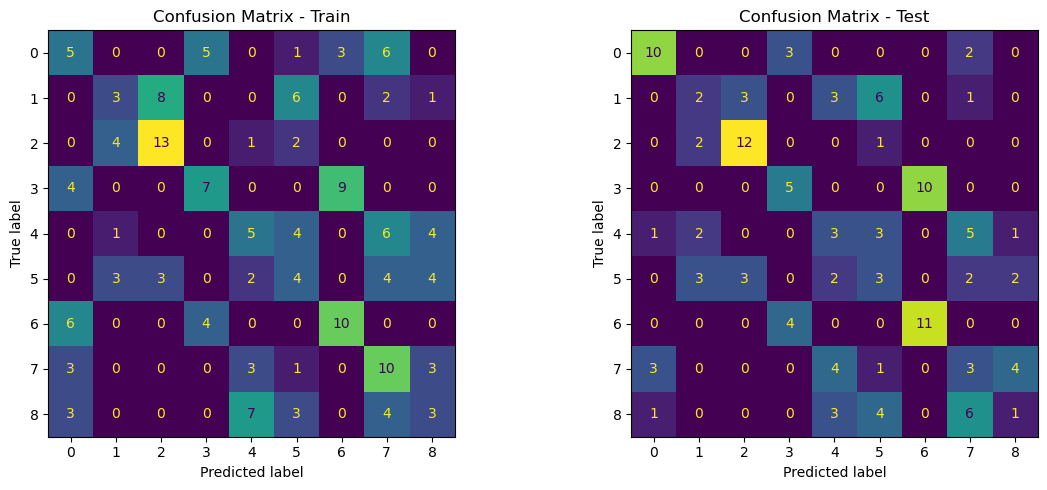

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

# %%%%% TODO %%%%%
# Appliquer la classification LDA
resultsMean = classify_by_LDA(MeanTrain, MeanTest)

# Print les résultats
print("Accuracy (Train) :", resultsMean['train_acc'])
print("Accuracy (Test) :", resultsMean['test_acc'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(resultsMean['train_cm']).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix - Train")
ConfusionMatrixDisplay(resultsMean['test_cm']).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix - Test")
plt.tight_layout()
plt.show()

# %%%%% end TODO %%%%% 

1.5 TODO : Commenter le résultat. Naïvement, la moyenne d'échantillon vous semble t'elle être un bon marqueur pour ces données ?

## Etape 2 : LDA avec la matrice d'autocovariance

Autocovariance : https://fr.wikipedia.org/wiki/Autocovariance  
Autocorrélation : https://fr.wikipedia.org/wiki/Autocorr%C3%A9lation

Soit le vecteur translation $\tau = (\tau_1, \tau_2)$ avec $\tau_1 = 0, 1, ... dn$ et $\tau_2 = -dn, ..., -1, 0, 1, ... dn$. On note $X(u)$ la valeur de l'image $X$ en le pixel $u$. L'autocovariance du processus $X$ (supposé à valeurs réelles) est définie par:

$$\phi(u, \tau) = \mathbb{E} [(X(u)-\mu_u)(X(u-\tau)-\mu_{u-\tau})]$$

**2.1 TODO:** Qu'entend on par $\mathbb E$ dans une telle définition ? Que représentent $\mu_u$ et $\mu_{u-\tau}$ ? À quelle condition l'autocovariance ne dépend que de $\tau$ ? Jusitifer alors l'appelation "matrice d'autocovariance" dans notre cas et donner ses dimensions en fonction du choix de $dn$.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

- $\mathbb{E}$ désigne l'espérance mathématique, c'est-à-dire la moyenne prise sur toutes les réalisations possibles du processus aléatoire $X$. Dans le contexte d'une image, cela correspond à une moyenne sur l'ensemble des pixels ou sur un ensemble d'images similaires.

- $\mu_u$ et $\mu_{u-\tau}$ représentent respectivement la moyenne de $X$ au pixel $u$ et au pixel $u-\tau$. Autrement dit, ce sont les valeurs moyennes locales du processus en ces positions.

- L'autocovariance ne dépend que de $\tau$ (et non de $u$) si le processus est **stationnaire** (invariant par translation). Cela signifie que les propriétés statistiques de l'image sont les mêmes en tout point, donc la moyenne et la covariance ne dépendent que du décalage $\tau$.

- Dans notre cas, on suppose que les images sont stationnaires, donc on parle de **matrice d'autocovariance** car pour chaque décalage $\tau = (\tau_1, \tau_2)$, on peut calculer une valeur d'autocovariance. En faisant varier $\tau_1$ de $0$ à $dn$ et $\tau_2$ de $-dn$ à $dn$, la matrice d'autocovariance aura pour dimensions $(dn+1) \times (2dn+1)$.

</div>

**2.2 TODO :** Proposer un estimateur de la matrice d'autocovariance calculé à partir d'une seule image. Ecrire une fonction qui calcule cet estimateur pour un $dn$ donné. La fonction retournera un dictionnaire de numpy arrays où chaque élément correspond à une classe.  

In [14]:
def compute_features_cov(Imgs: dict, dn: int, NbClasses: int, NbMaps: int) -> dict:
    covmat_cls = {}
    for i in range(NbClasses):  # Boucle sur les classes
        # %%%%% TODO %%%%%
        covmat = np.zeros((NbMaps, dn + 1, 2 * dn + 1))
        for j in range(NbMaps):
            img = Imgs[i][j]
            mu = np.mean(img)
            for dx in range(dn + 1):
                for dy in range(-dn, dn + 1):
                    shifted = np.roll(img, shift=(-dx, -dy), axis=(0, 1))
                    covmat[j, dx, dy + dn] = np.mean((img - mu) * (shifted - mu))
        covmat_cls[i] = covmat
        # %%%%% end TODO %%%%%
        
    return covmat_cls

**2.3 TODO :** Pour un $dn$ entre 0 et 8, calculer ces estimateurs de matrices de covariance sur les données Train et Test et réaliser une classification par LDA. Tracer les tests d'accuracy en fonction de $dn$. 

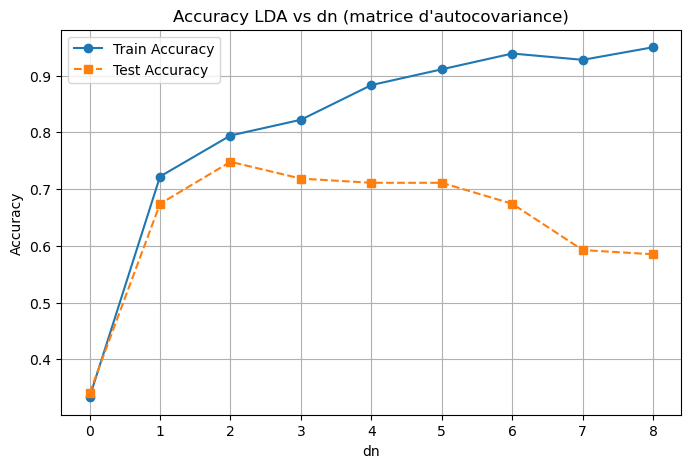

In [15]:
# %%%%% TODO %%%%%
dn_range = range(0, 9)
accuracy_train = []
accuracy_test = []

for dn in dn_range:
    CovTrain = compute_features_cov(ImgsTrain, dn, NbClasses, NbMapsTrain)
    CovTest = compute_features_cov(ImgsTest, dn, NbClasses, NbMapsTest)
    resultsCov = classify_by_LDA(CovTrain, CovTest)
    accuracy_train.append(resultsCov['train_acc'])
    accuracy_test.append(resultsCov['test_acc'])

plt.figure(figsize=(8, 5))
plt.plot(dn_range, accuracy_train, 'o-', label='Train Accuracy')
plt.plot(dn_range, accuracy_test, 's--', label='Test Accuracy')
plt.xlabel('dn')
plt.ylabel('Accuracy')
plt.title('Accuracy LDA vs dn (matrice d\'autocovariance)')
plt.legend()
plt.grid(True)
plt.show()

# %%%%% end TODO %%%%%

**2.4 TODO :** Commenter ces résultats et comparer brièvement à ceux obtenus à l'étape 1.

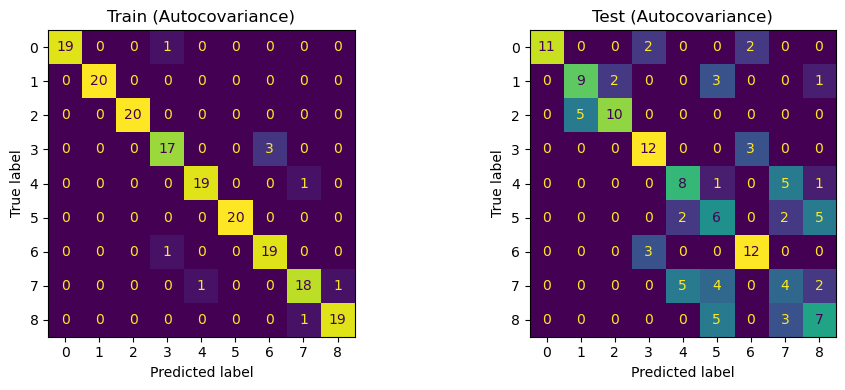

Accuracy (Autocovariance) : Train = 0.95 , Test = 0.5851851851851851


In [16]:
# Affichage des matrices de confusion pour l'étape 2 (autocovariance)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(resultsCov['train_cm']).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Train (Autocovariance)")

ConfusionMatrixDisplay(resultsCov['test_cm']).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Test (Autocovariance)")

plt.tight_layout()
plt.show()

print("Accuracy (Autocovariance) : Train =", resultsCov['train_acc'], ", Test =", resultsCov['test_acc'])


<div style="background-color:rgba(255, 0,0, 0.1);padding:15px;">

L'étape 2 (autocovariance) donne des matrices de confusion beaucoup plus diagonales et des taux de bonne classification nettement supérieurs à l'étape 1 (moyenne).  

Cela montre que l'autocovariance capture mieux la structure des images et permet une meilleure séparation des classes que la simple moyenne, qui est trop pauvre en information pour ce problème.

</div>

## Etape 3: LDA en utilisant le spectre de puissance (periodogram)

**3.1 TODO :** Rappeler le lien entre autocovariance et spectre de puissance.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

Le lien entre l'autocovariance et le spectre de puissance est établi par la **transformée de Fourier**. En effet, le spectre de puissance d'un signal (ou d'une image) est la transformée de Fourier de sa fonction d'autocovariance. Plus précisément, si $\phi(u, \tau)$ est l'autocovariance du signal $X$, alors le spectre de puissance $P(f)$ est donné par :
$$ P(f) = \mathcal{F}\{\phi(u, \tau)\} $$
où $\mathcal{F}$ est l'opérateur de transformée de Fourier. Cela signifie que le spectre de puissance contient des informations sur la distribution de l'énergie du signal dans le domaine fréquentiel, tandis que l'autocovariance fournit des informations sur la corrélation spatiale du signal dans le domaine spatial.
</div>

**3.2 TODO :** Ecrire une fonction qui calcule le spectre de puissance de chaque image pour une fréquence maximale notée $dom$. Elle devra retourner un dictionnaire de numpy arrays, chaque élément du dictionnaire étant associé à une classe. On utilisera `fft2` de la librairie `scipy`. Caluler d'abord le spectre de puissance complet puis le tronquer à la fréquence maximale $dom$.

La fonction pourra plotter le spectre de puissance complet et tronqué pour une image en particulier.

In [17]:
def compute_features_ps(Imgs: dict, dom: int, NbClasses: int, NbMaps: int, SizeMaps: int, plot: bool = False) -> dict:
    psmat_cls = {}
    for i in range(NbClasses):
        psmat = np.zeros((NbMaps, 2*dom+1, 2*dom+1))
        for j in range(NbMaps):
            # %%%%% TODO %%%%%
            img = Imgs[i][j]
            # Calcul du spectre de puissance complet
            ps_full = np.abs(fft2(img))**2 / (SizeMaps * SizeMaps)
            ps_full_shifted = np.fft.fftshift(ps_full)

            # Tronquage autour du centre (fréquence nulle)
            center = SizeMaps // 2
            ps_trunc = ps_full_shifted[
                center - dom : center + dom + 1,
                center - dom : center + dom + 1
            ]
            psmat[j] = ps_trunc

            # Plot pour la première image de la première classe si demandé
            if plot and i == 0 and j == 0:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(np.log10(ps_full_shifted + 1e-8), cmap='inferno')
                plt.title('Spectre de puissance complet (log)')
                plt.colorbar()
                plt.subplot(1, 2, 2)
                plt.imshow(np.log10(ps_trunc + 1e-8), cmap='inferno')
                plt.title(f'Spectre tronqué dom={dom} (log)')
                plt.colorbar()
                plt.tight_layout()
                plt.show()
                
            # %%%%% end TODO %%%%%
        psmat_cls[i] = psmat

    return psmat_cls


**3.3 TODO :** Quelle plage de valeurs du métaparamètre $dom$ proposez vous d'étudier et pourquoi ? Pour différents choix de $dom$ que vous proposerez, calculer les spectres de puissance sur les données Train et Test. Puis effectuer une classification par LDA. Tracer les tests d'accuracy en fonction de $dom$.

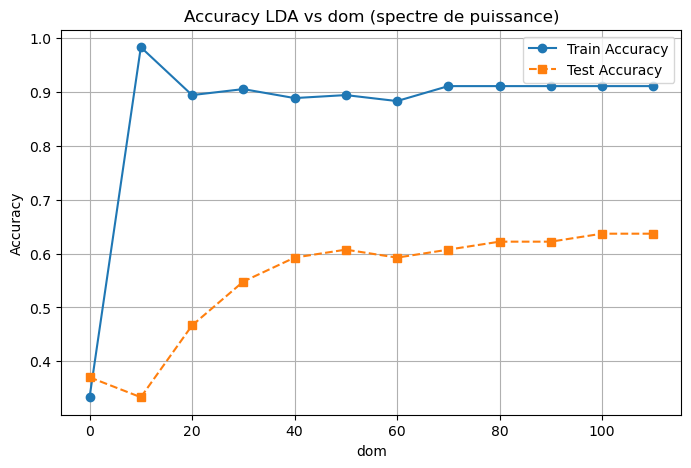

In [29]:
# %%%%% TODO %%%%%
dom_range = range(0, 120, 10)
accuracy_train_ps = []
accuracy_test_ps = []

for dom in dom_range:
    PSTrain = compute_features_ps(ImgsTrain, dom, NbClasses, NbMapsTrain, SizeMaps, plot=False)
    PSTest = compute_features_ps(ImgsTest, dom, NbClasses, NbMapsTest, SizeMaps)
    resultsPS = classify_by_LDA(PSTrain, PSTest)
    accuracy_train_ps.append(resultsPS['train_acc'])
    accuracy_test_ps.append(resultsPS['test_acc'])

plt.figure(figsize=(8, 5))
plt.plot(dom_range, accuracy_train_ps, 'o-', label='Train Accuracy')
plt.plot(dom_range, accuracy_test_ps, 's--', label='Test Accuracy')
plt.xlabel('dom')
plt.ylabel('Accuracy')
plt.title('Accuracy LDA vs dom (spectre de puissance)')
plt.legend()
plt.grid(True)
plt.show()

# %%%%% end TODO %%%%%

**3.4 TODO :** Commenter ces résultats.

## Analyse des performances et conclusion 

Le but de cette section est de comparer les trois classifications LDA réalisées ci-dessus en terme de performances :
- Quelle méthode obtient les meilleurs résultats ?
- Quelle est celle qui a les plus grandes erreurs ?
- Comment l'erreur est-elle reliée à la variance des features choisis ?

Pour aider à répondre à ces questions, on définit la fonction plot suivante :

In [19]:
def plot_mean_per_class(results:dict, dataT: dict, NbMaps: int, title: str, log_yscale: bool):

    fig = plt.figure(figsize=(10,10))
    fig.suptitle(title)  
    ymax = max(list(map(np.max, dataT.values())))
    ymin = min(list(map(np.min, dataT.values())))
    for i in range(NbClasses):            
        plt.subplot(3, 3, i+1)
        for j in range(NbMaps):
            features = dataT[i][j,...].reshape(-1)
            plt.plot(features, color='b', alpha=.3)

        plt.plot(results['lda'].means_[i], color='r')
        plt.title(f'Class {i}')
        plt.ylim([ymin, ymax])
        plt.yscale('log') if log_yscale else None
    plt.show()

    fig = plt.figure(figsize=(18,6))
    fig.suptitle(title)  
    for i in range(NbClasses):         
        errors = dataT[i].std(axis=0).reshape(-1)
        plt.errorbar(x=range(len(results['lda'].means_[i])), y=results['lda'].means_[i], yerr=errors, label='class {:}'.format(i))

    plt.ylim([ymin, ymax])
    plt.legend()
    plt.show()
        
    return

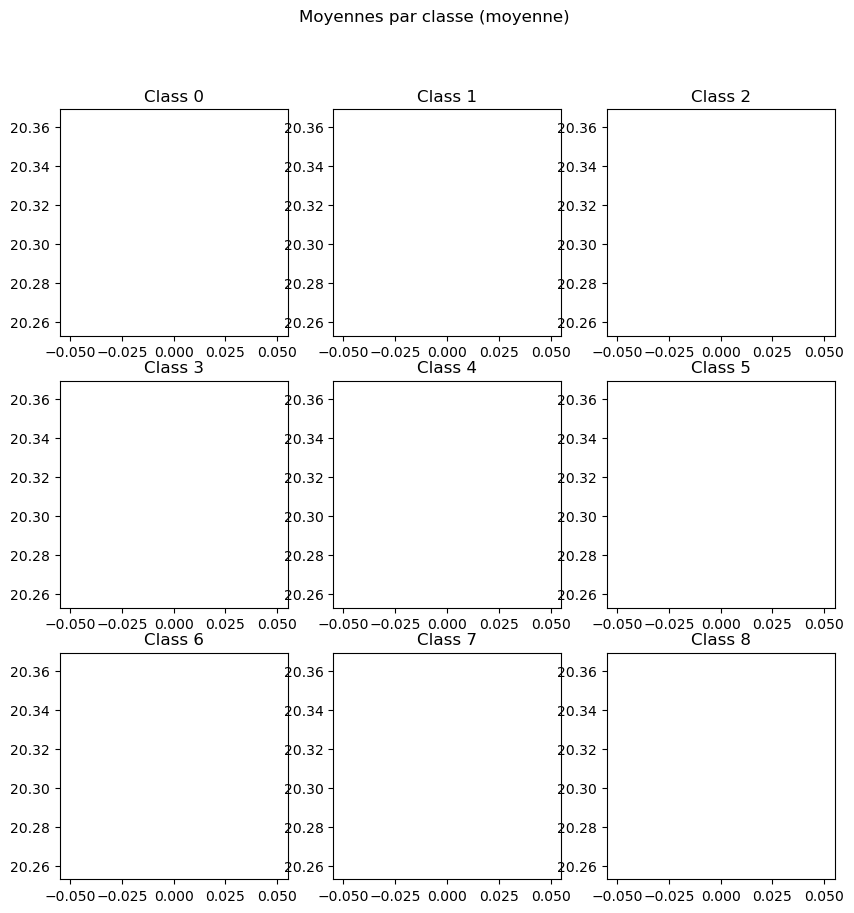

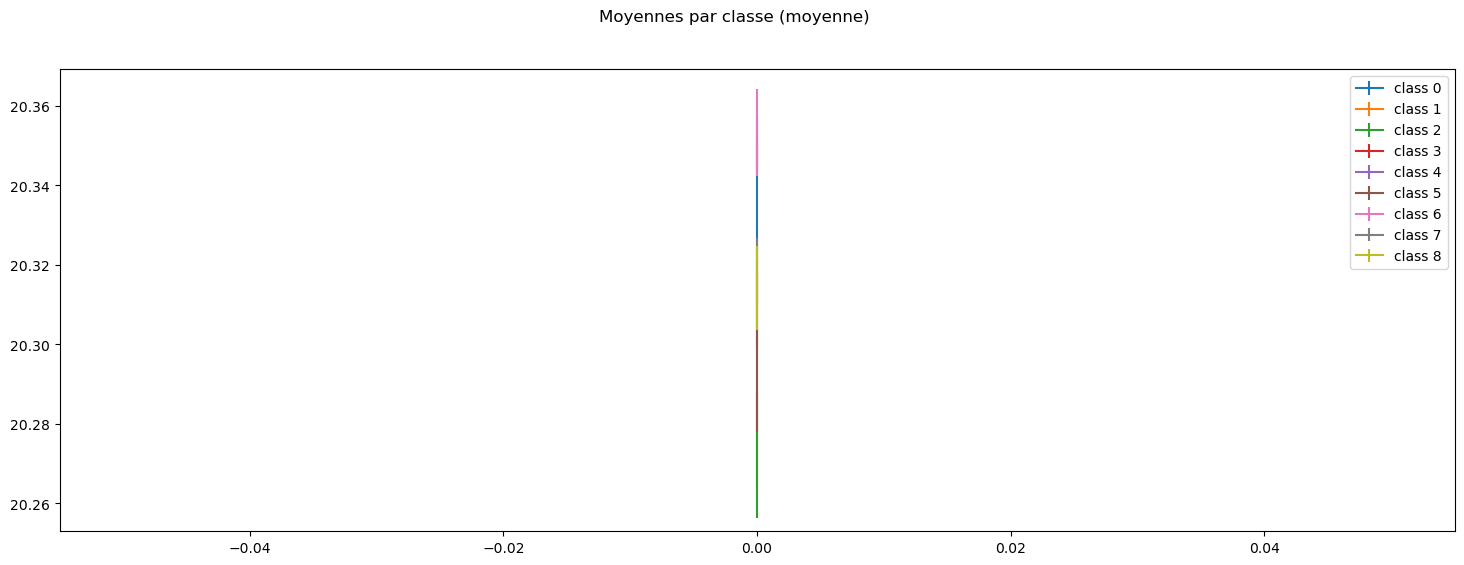

In [27]:
plot_mean_per_class(resultsMean, MeanTrain, NbMapsTrain, 'Moyennes par classe (moyenne)', log_yscale=False)

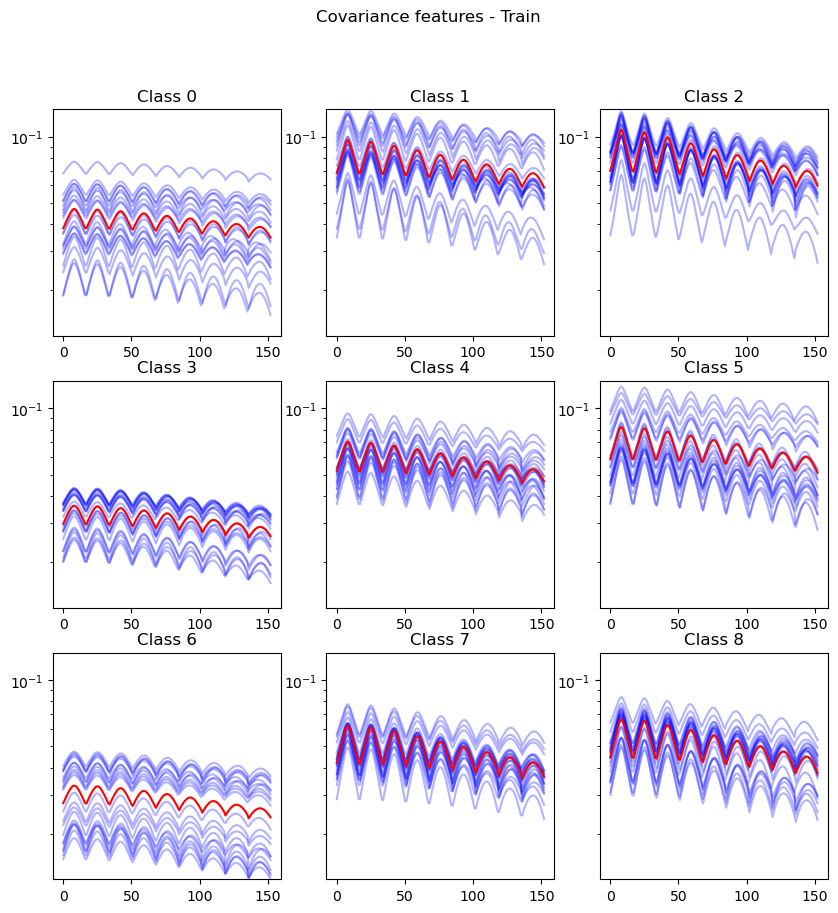

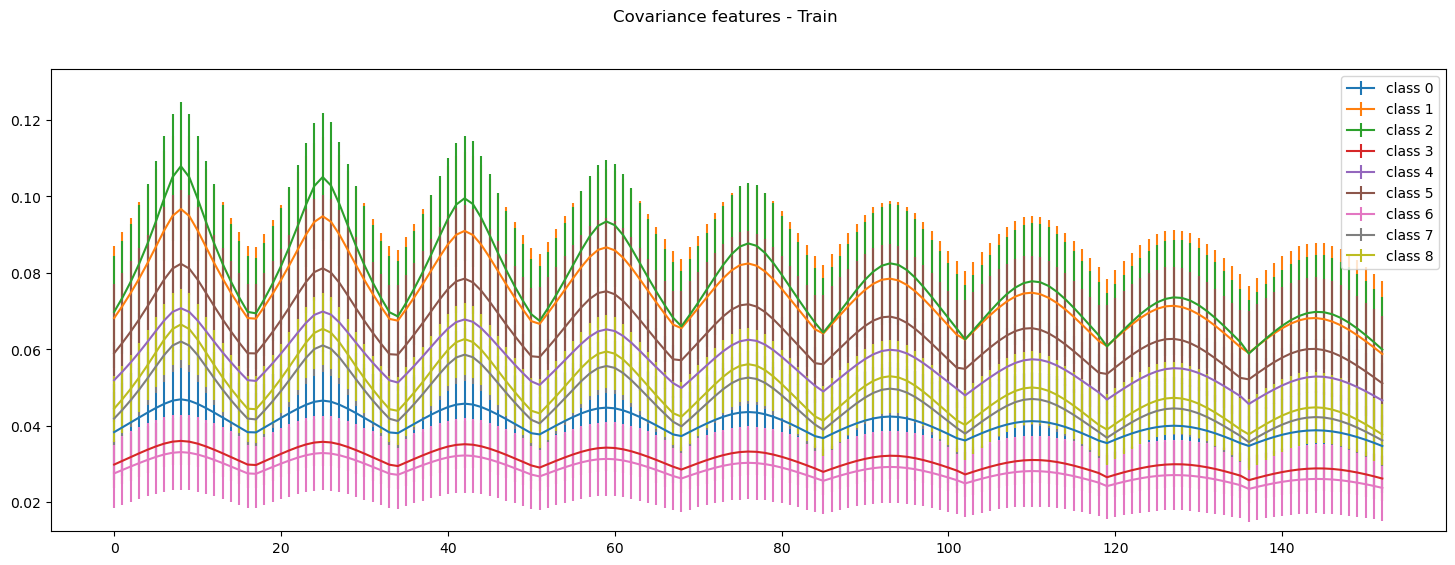

In [25]:
plot_mean_per_class(resultsCov, CovTrain, NbMapsTrain,
                    title='Covariance features - Train', log_yscale=True)

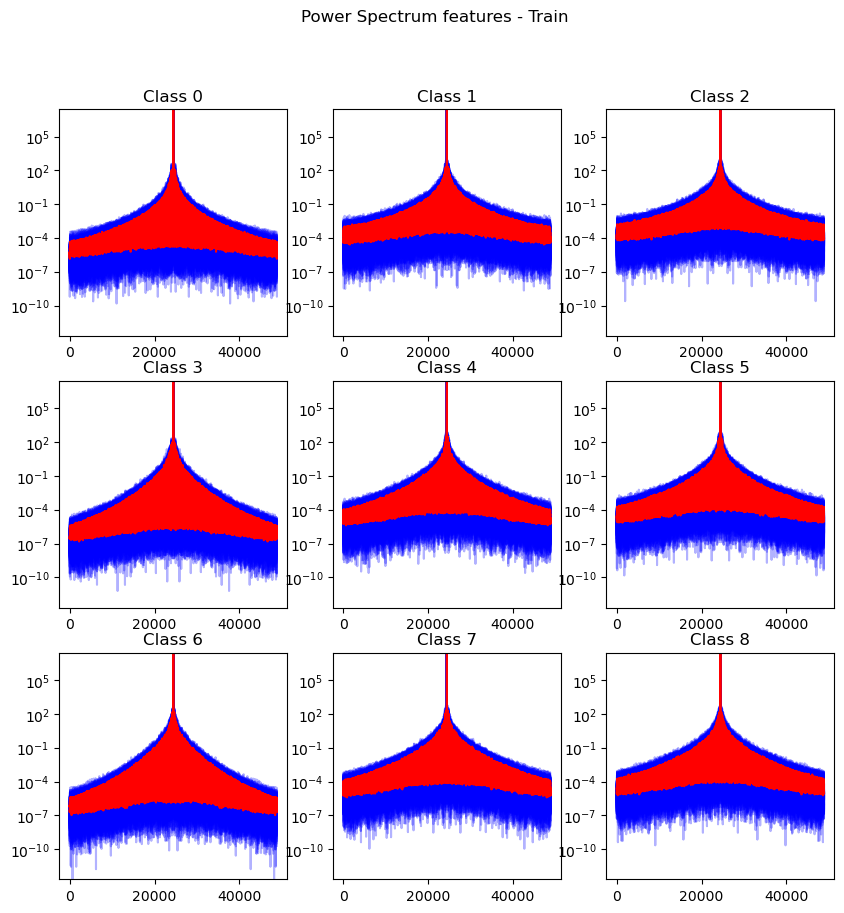

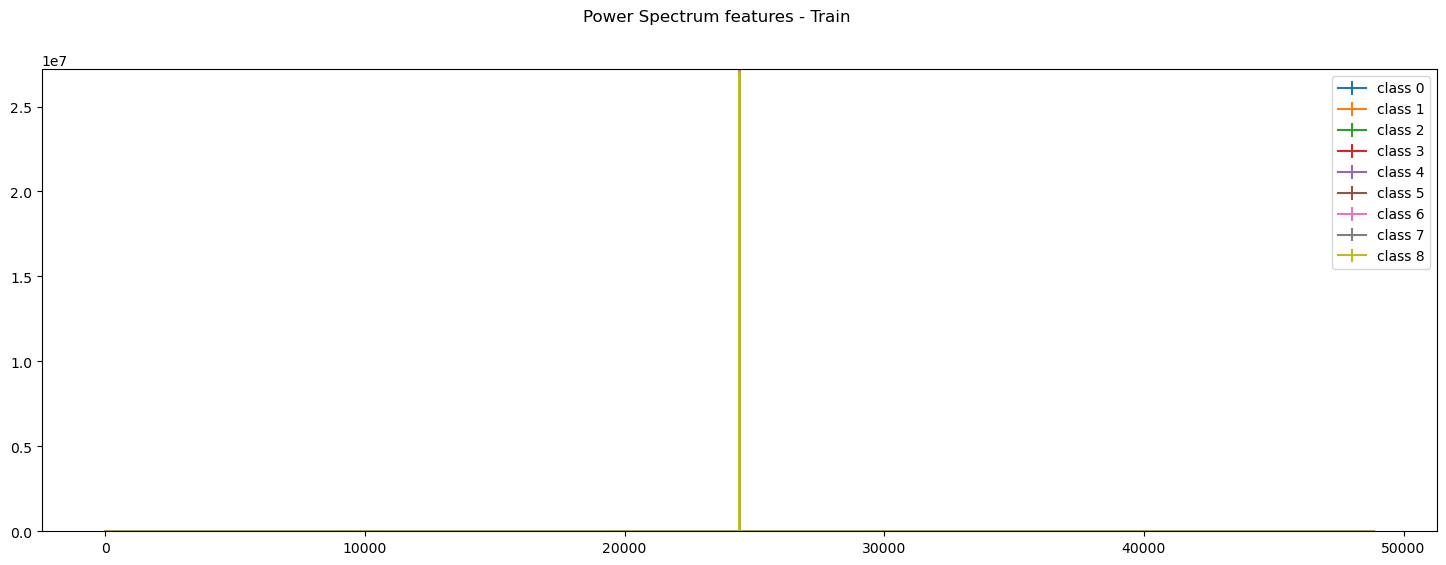

In [26]:
plot_mean_per_class(resultsPS, PSTrain, NbMapsTrain,
                    title='Power Spectrum features - Train', log_yscale=True)

**4.1 TODO :** Conclure sur les performances de la LDA sur ces trois choix de features.

=== Performances LDA ===
Moyenne : Accuracy Train = 0.33, Test = 0.37
Autocovariance : Accuracy Train = 0.95, Test = 0.59
Spectre de puissance : Accuracy Train = 0.91, Test = 0.64


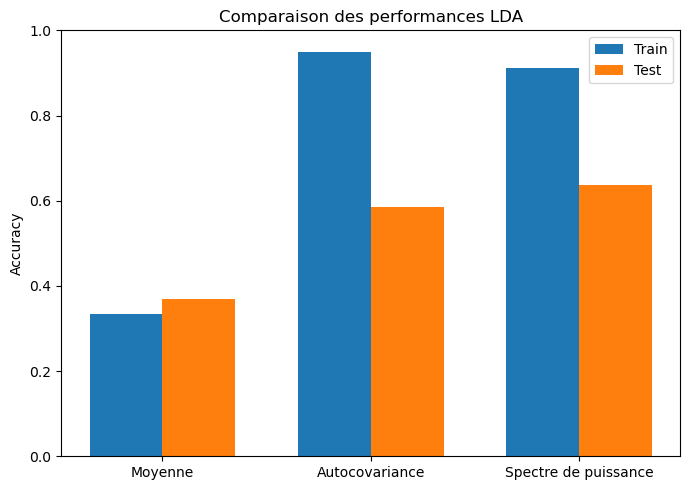

In [21]:
# %%%%% TODO %%%%%
print("=== Performances LDA ===")
print(f"Moyenne : Accuracy Train = {resultsMean['train_acc']:.2f}, Test = {resultsMean['test_acc']:.2f}")
print(f"Autocovariance : Accuracy Train = {resultsCov['train_acc']:.2f}, Test = {resultsCov['test_acc']:.2f}")
print(f"Spectre de puissance : Accuracy Train = {resultsPS['train_acc']:.2f}, Test = {resultsPS['test_acc']:.2f}")

# Affichage synthétique des performances
labels = ['Moyenne', 'Autocovariance', 'Spectre de puissance']
train_acc = [resultsMean['train_acc'], resultsCov['train_acc'], resultsPS['train_acc']]
test_acc = [resultsMean['test_acc'], resultsCov['test_acc'], resultsPS['test_acc']]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, train_acc, width, label='Train')
plt.bar(x + width/2, test_acc, width, label='Test')
plt.xticks(x, labels)
plt.ylabel('Accuracy')
plt.title('Comparaison des performances LDA')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# %%%%% end TODO %%%%%

**4.2 TODO :** Quelle invariance de groupe n'a pas été exploitée dans la construction des deux derniers features ?

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

L'invariance de groupe qui n'a pas été exploitée est **l'invariance par rotation**.
</div>

**4.3 TODO :** En se basant sur les analyses précédentes et une exploration complémentaire, proposer une feature compressée avec une bonne accuracy. 

*Cette question est plus ouverte que les autres. Il n'est pas attendu une feature en particulier, mais des choix d'exploration motivés. La mise en application des concepts étudiés dans le cours, la prise en compte des résultats obtenus précédemment, l'effort de recherche et les illustrations seront valorisés.*

In [31]:
# %%%%% TODO %%%%%
# Exemple : Utilisation du spectre de puissance azimutal moyen (invariant par rotation)
def compute_features_ps_azimuthal(Imgs: dict, dom: int, NbClasses: int, NbMaps: int, SizeMaps: int, n_bins: int = 20, plot: bool = False) -> dict:
    """
    Calcule le spectre de puissance azimutal moyen (invariant par rotation).
    On regroupe les valeurs du spectre de puissance tronqué par distance au centre (fréquence nulle).
    """
    psmat_cls = {}
    for i in range(NbClasses):
        psmat = np.zeros((NbMaps, n_bins))
        for j in range(NbMaps):
            img = Imgs[i][j]
            ps_full = np.abs(fft2(img))**2 / (SizeMaps * SizeMaps)
            ps_full_shifted = np.fft.fftshift(ps_full)
            center = SizeMaps // 2
            ps_trunc = ps_full_shifted[
                center - dom : center + dom + 1,
                center - dom : center + dom + 1
            ]
            # Coordonnées polaires
            y, x = np.indices(ps_trunc.shape)
            r = np.sqrt((x - dom)**2 + (y - dom)**2)
            r = r.flatten()
            ps_flat = ps_trunc.flatten()
            # Binning radial
            r_max = np.max(r)
            bins = np.linspace(0, r_max, n_bins + 1)
            bin_means = np.zeros(n_bins)
            for k in range(n_bins):
                mask = (r >= bins[k]) & (r < bins[k+1])
                if np.any(mask):
                    bin_means[k] = np.mean(ps_flat[mask])
                else:
                    bin_means[k] = 0
            psmat[j] = bin_means

            # Plot pour la première image de la première classe
            if plot and i == 0 and j == 0:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(np.log10(ps_trunc + 1e-8), cmap='inferno')
                plt.title('Spectre tronqué (log)')
                plt.colorbar()
                plt.subplot(1, 2, 2)
                plt.plot(bin_means, 'o-')
                plt.title('Profil azimutal moyen')
                plt.xlabel('Bin radial')
                plt.ylabel('Moyenne spectre')
                plt.tight_layout()
                plt.show()

        psmat_cls[i] = psmat

    return psmat_cls

# %%%%% end TODO %%%%%

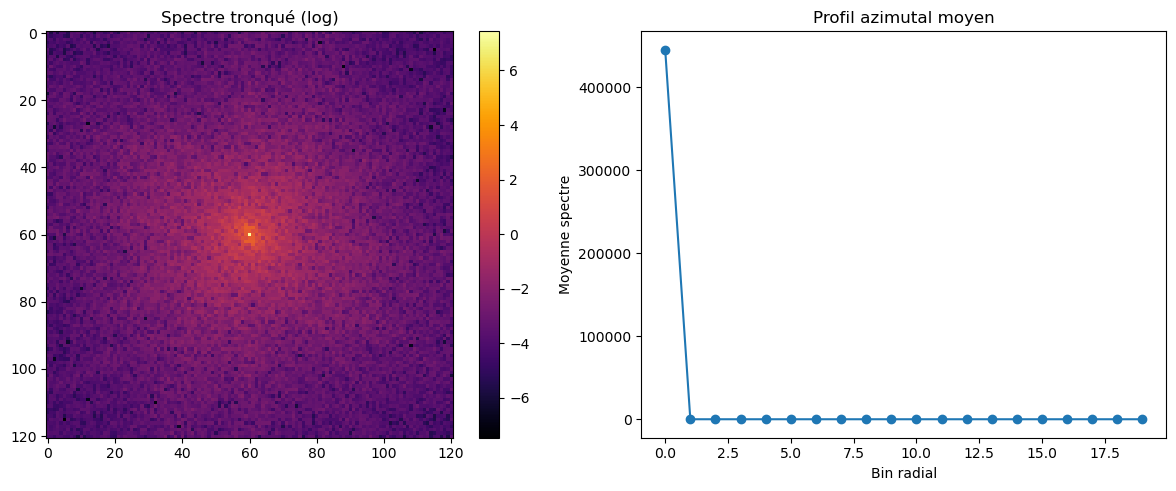

Accuracy (Train, azimutal PS): 0.7777777777777778
Accuracy (Test, azimutal PS): 0.6666666666666666


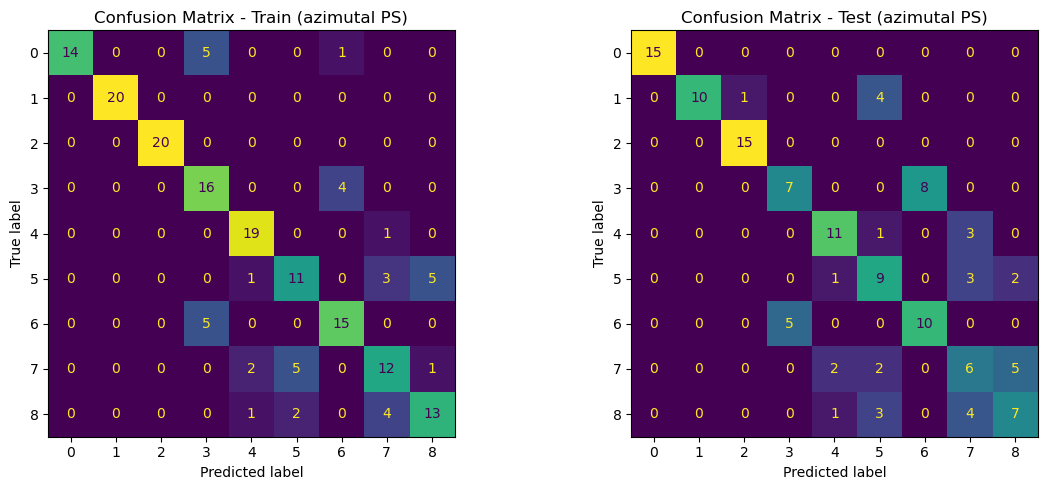

In [ ]:
# Calcul des features azimutaux
dom_az = 60
n_bins = 20
PSTrain_az = compute_features_ps_azimuthal(ImgsTrain, dom_az, NbClasses, NbMapsTrain, SizeMaps, n_bins=n_bins, plot=True)
PSTest_az = compute_features_ps_azimuthal(ImgsTest, dom_az, NbClasses, NbMapsTest, SizeMaps, n_bins=n_bins)

# Classification LDA
resultsPS_az = classify_by_LDA(PSTrain_az, PSTest_az)
print("Accuracy (Train, azimutal PS):", resultsPS_az['train_acc'])
print("Accuracy (Test, azimutal PS):", resultsPS_az['test_acc'])

# Affichage des matrices de confusion
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(resultsPS_az['train_cm']).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix - Train (azimutal PS)")
ConfusionMatrixDisplay(resultsPS_az['test_cm']).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix - Test (azimutal PS)")
plt.tight_layout()
plt.show()
